##### The University of Melbourne, School of Computing and Information Systems
# COMP30027 Machine Learning, 2022 Semester 1

## Assignment 2: Sentiment Classification of Tweets

This is a sample code to assist you with vectorising the 'Train' dataset for your assignment 2.

First we read the CSV datafiles (Train and Test).

In [34]:
import pandas as pd
import numpy as np

train_data = pd.read_csv("Train.csv", sep=',')
test_data = pd.read_csv("Test.csv", sep=',')


,count
neutral,12659
positive,5428
negative,3715


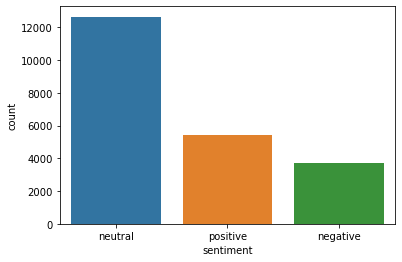

In [35]:
import seaborn as sns

# imbalance of the labels
train_labels = sns.countplot(x="sentiment", data=train_data)

d = {'count': train_data['sentiment'].value_counts()}
pd.DataFrame(d)

In [36]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

import re

stop_words = stopwords.words('english')
sw = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    
    text = text.lower()
    # replace everything with space except (a-z, A-Z, ".", "?", "!", ",")
    text = re.sub(r"[^a-zA-Z?.!,¿]+", " ", text)
    # removing URLs
    text = re.sub(r"http\S+", "",text) 
    
    html = re.compile(r'<.*?>') 
    
    # remove html tags
    text = html.sub(r'',text) 
    
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`" + '_'
    for p in punctuations:
        # remove punctuations
        text = text.replace(p,'') 
        
    text = [word.lower() for word in text.split() if word.lower() not in sw]
    
    # lemmatize verbs
    text = [lemmatizer.lemmatize(word, 'v') for word in text]
    # lemmatize nouns
    text = [lemmatizer.lemmatize(word, 'n') for word in text]
    
    # remove stopwords
    text = " ".join(text) 
    
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    # remove emojis
    text = emoji_pattern.sub(r'', text) 
    
    return text

train_data['text'] = train_data['text'].apply(lambda x: preprocess(x))
test_data['text'] = test_data['text'].apply(lambda x: preprocess(x))


Then we separate the tweet text and the label (sentiment). 

In [37]:
#separating instance and label for Train
X_train_raw = [x[0] for x in train_data[['text']].values]
Y_train = [x[0] for x in train_data[['sentiment']].values]


#check the result
print("Train length:",len(X_train_raw))

#separating instance and label for Test
X_test_raw = [x[0] for x in test_data[['text']].values]

#check the result
print("Test length:", len(X_test_raw))


Train length: 21802
Test length: 6099


In [38]:
#Let's see one example tweet
print(X_train_raw[1])

anybody go radio station tomorrow see shawn friend may go would like make new friend meet


In [42]:
from sklearn.model_selection import train_test_split

# 90:10 split the train data into train & holdout validation set for sampling a large data 
X_train, X_dev, y_train, y_dev = train_test_split(X_train_raw, Y_train, test_size=0.1)


### 2. TFIDF
In this approach, we use the **TfidfVectorizer** library to separate all the words in this corpus (dataset). Same as the BoW approach, these words are then used as the 'vectors' or 'features' to represent each instance (Tweet).

However, in this method for each instance the value associated with each 'vector' (word) is not the number of times the word repeated in that tweet, but the TFIDF value of then 'voctor' (word).

In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(stop_words = 'english', min_df = 5, max_df = 0.8, ngram_range=(1, 3))

# build the feature set (vocabulary) and vectorise the Train dataset using TFIDF
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# use the feature set (vocabulary) from Train to vectorise the Dev and Test dataset 
X_dev_tfidf = tfidf_vectorizer.transform(X_dev)
X_test_tfidf = tfidf_vectorizer.transform(X_test_raw)

print("Train feature space size (using TFIDF):",X_train_tfidf.shape)
print("Dev feature space size (using TFIDF):",X_dev_tfidf.shape)
print("Test feature space size (using TFIDF):",X_test_tfidf.shape)


Train feature space size (using TFIDF): (19621, 7260)
Dev feature space size (using TFIDF): (2181, 7260)
Test feature space size (using TFIDF): (6099, 7260)


In [69]:
#Let's see one example tweet using the TFIDF feature space
print(X_train_tfidf[0])

  (0, 7142)	0.3218170628240632
  (0, 726)	0.2428483356556669
  (0, 4347)	0.35640828698792015
  (0, 4939)	0.23117128230527378
  (0, 7134)	0.2370673938941343
  (0, 7144)	0.35640828698792015
  (0, 3537)	0.21772420740033518
  (0, 102)	0.2904063790780171
  (0, 3436)	0.24231244937844257
  (0, 725)	0.24178338986383024
  (0, 4008)	0.348836361471318
  (0, 4955)	0.19082032506707522
  (0, 4345)	0.258360579594547


In [57]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix,classification_report

mnb = MultinomialNB()
mnb.fit(X_train_tfidf, y_train)

print("Training Accuracy:", mnb.score(X_train_tfidf, y_train))
print("Holdout Accuracy:", mnb.score(X_dev_tfidf, y_dev))
mnb_y_pred = mnb.predict(X_dev_tfidf)

print(mnb_y_pred)
print(classification_report(y_dev, mnb_y_pred))

Training Accuracy: 0.7022577850262474
Holdout Accuracy: 0.6501604768454837
['neutral' 'positive' 'neutral' ... 'negative' 'neutral' 'neutral']
              precision    recall  f1-score   support

    negative       0.61      0.20      0.31       354
     neutral       0.65      0.90      0.75      1273
    positive       0.69      0.35      0.47       554

    accuracy                           0.65      2181
   macro avg       0.65      0.49      0.51      2181
weighted avg       0.65      0.65      0.61      2181



In [58]:
# 5-fold cross validation
# pipeline multinomial

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest, chi2

folds = StratifiedKFold(n_splits=5)

pipeline = Pipeline([
    ('TfidfVectorizer', TfidfVectorizer(stop_words='english', min_df=5, max_df=0.8, ngram_range=(1, 3))),
    ('Chi',  SelectKBest(chi2, k=1500)),
    ('Multinomial', MultinomialNB())])

scores = cross_val_score(pipeline, X_train_raw, Y_train, cv=folds)

print("Stratified 5-fold CV Mean Accuracy:", scores.mean())
print(scores)

Stratified 5-fold Cross Validation Averaged Accuracy: 0.6335651279375785
[0.64618207 0.63402889 0.64013761 0.61995413 0.62752294]


In [90]:
# gridsearch for the best lin SVC parameters 

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# defining parameter range
grid = {'C': [0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0],
              'kernel': ['linear']}
 
svm_search = GridSearchCV(SVC(), grid)

# fitting the model for grid search
svm_search.fit(X_train_tfidf, y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0],
                         'kernel': ['linear']})

In [91]:
# print best parameter after tuning
print(svm_search.best_params_)
 
# print how our model looks after hyper-parameter tuning
print(svm_search.best_estimator_)
print("accuracy :", svm_search.best_score_)

{'C': 1.0, 'kernel': 'linear'}
SVC(kernel='linear')
accuracy : 0.6593443580903406


In [59]:
from sklearn.svm import LinearSVC

linsvm = LinearSVC(C=1)
linsvm.fit(X_train_tfidf, y_train)

print("Training Accuracy:", linsvm.score(X_train_tfidf, y_train))
print("Holdout Accuracy:", linsvm.score(X_dev_tfidf, y_dev))
linsvm_y_pred = linsvm.predict(X_dev_tfidf)

print(linsvm_y_pred)
print(classification_report(y_dev, linsvm_y_pred))


Training Accuracy: 0.8230467356403853
Holdout Accuracy: 0.657496561210454
['negative' 'positive' 'neutral' ... 'negative' 'negative' 'neutral']
              precision    recall  f1-score   support

    negative       0.52      0.39      0.45       354
     neutral       0.69      0.79      0.74      1273
    positive       0.62      0.52      0.57       554

    accuracy                           0.66      2181
   macro avg       0.61      0.57      0.58      2181
weighted avg       0.65      0.66      0.65      2181



In [60]:
# 5-fold cross validation
# pipeline lin SVM

pipeline = Pipeline([
    ('TfidfVectorizer', TfidfVectorizer(stop_words='english', min_df=5, max_df=0.8, ngram_range=(1, 3))),
    ('Chi',  SelectKBest(chi2, k=1500)),
    ('Linear SVM', LinearSVC(C=1))])

scores = cross_val_score(pipeline, X_train_raw, Y_train, cv=folds)

print("Stratified 5-fold CV Mean Accuracy:", scores.mean())
print(scores)


Stratified 5-fold Cross Validation Averaged Accuracy: 0.6604432637914459
[0.67507452 0.66177482 0.67522936 0.63899083 0.65114679]


In [144]:
# gridsearch for the best logistic regression parameters 
from sklearn.linear_model import LogisticRegression

# defining parameter range
grid = {'C': [0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0]}
 
lg_search = GridSearchCV(LogisticRegression(max_iter=10000), grid, cv=5)

# fitting the model for grid search
lg_search.fit(X_train_tfidf, y_train)

NameError: name 'lg_svm_search' is not defined

In [ ]:
# print best parameter after tuning
print(lg_search.best_params_)
 
# print how our model looks after hyper-parameter tuning
print(lg_search.best_estimator_)
print("accuracy :", lg_search.best_score_)

In [77]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(C=1, max_iter=5000)
logreg.fit(X_train_tfidf, y_train)

print("Training Accuracy:", logreg.score(X_train_tfidf, y_train))
print("Holdout Accuracy:", logreg.score(X_dev_tfidf, y_dev))
logreg_y_pred = logreg.predict(X_dev_tfidf)

print(logreg_y_pred)
print(classification_report(y_dev, logreg_y_pred))


Training Accuracy: 0.7554660822588043
Holdout Accuracy: 0.6785878037597433
['negative' 'neutral' 'neutral' ... 'negative' 'neutral' 'neutral']
              precision    recall  f1-score   support

    negative       0.61      0.29      0.40       354
     neutral       0.68      0.87      0.77      1273
    positive       0.68      0.49      0.57       554

    accuracy                           0.68      2181
   macro avg       0.66      0.55      0.58      2181
weighted avg       0.67      0.68      0.66      2181



In [86]:
# 5-fold cross validation
# pipeline logistic regression

pipeline = Pipeline([
    ('TfidfVectorizer', TfidfVectorizer(stop_words='english', min_df=5, max_df=0.8, ngram_range=(1, 3))),
    ('Chi',  SelectKBest(chi2, k=1500)),
    ('Logistic Regression', LogisticRegression(C=1, max_iter=5000))])

scores = cross_val_score(pipeline, X_train_raw, Y_train, cv=folds)

print("Stratified 5-fold CV Mean Accuracy:", scores.mean())
print(scores)


5-fold CV Mean Accuracy: 0.6658093211514066
[0.68631048 0.67048842 0.67568807 0.64243119 0.65412844]


In [63]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=77)
knn.fit(X_train_tfidf, y_train)

print("Training Accuracy:", knn.score(X_train_tfidf, y_train))
print("Holdout Accuracy:", knn.score(X_dev_tfidf, y_dev))
knn_y_pred = knn.predict(X_dev_tfidf)

print(knn_y_pred)
print(classification_report(y_dev, knn_y_pred))

Training Accuracy: 0.6197441516742266
Holdout Accuracy: 0.6203576341127923
['neutral' 'positive' 'neutral' ... 'neutral' 'neutral' 'neutral']
              precision    recall  f1-score   support

    negative       0.60      0.09      0.15       354
     neutral       0.61      0.95      0.75      1273
    positive       0.70      0.19      0.30       554

    accuracy                           0.62      2181
   macro avg       0.64      0.41      0.40      2181
weighted avg       0.63      0.62      0.54      2181



In [64]:
# 5-fold cross validation
# pipeline KNN

pipeline = Pipeline([
    ('TfidfVectorizer', TfidfVectorizer(stop_words='english', min_df=5, max_df=0.8, ngram_range=(1, 3))),
    ('Chi',  SelectKBest(chi2, k=1500)),
    ('KNN', KNeighborsClassifier(n_neighbors=77))])

scores = cross_val_score(pipeline, X_train_raw, Y_train, cv=folds)

print("Stratified 5-fold CV Mean Accuracy:", scores.mean())
print(scores)

Stratified 5-fold Cross Validation Averaged Accuracy: 0.5889826001527299
[0.58977299 0.58954368 0.58922018 0.58692661 0.58944954]


In [88]:
# stacking

from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier

models = [
    ('MNB', MultinomialNB()),
    ('Logistic', LogisticRegression(C=1, max_iter=5000)),
    ('SVC', LinearSVC(C=1)),
    #('KNN', KNeighborsClassifier(n_neighbors=77)),
    ('RF', RandomForestClassifier(n_estimators=100))]

classifier = StackingClassifier(estimators=models)

classifier.fit(X_train_tfidf, y_train)
print('Training Accuracy:', classifier.score(X_train_tfidf, y_train))
print('Holdout Accuracy:', classifier.score(X_dev_tfidf, y_dev))


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training Accuracy: 0.8919524998725855
Holdout Accuracy: 0.6882164144887666


In [89]:
# 5-fold cross validation
# pipeline stacking

pipeline = Pipeline([
    ('TfidfVectorizer', TfidfVectorizer(stop_words='english', min_df=5, max_df=0.8, ngram_range=(1, 3))),
    ('Chi',  SelectKBest(chi2, k=1500)),
    ('Stacking', classifier)])

scores = cross_val_score(pipeline, X_train_raw, Y_train, cv=folds)

print("Stratified 5-fold CV Mean Accuracy:", scores.mean())
print(scores)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Stratified 5-fold CV Mean Accuracy: 0.6642044161237323
[0.6785141  0.6652144  0.6766055  0.64013761 0.66055046]


In [85]:
# create dataframe and save as csv using id and sentiments prediction of test set

def predict(train, raw_test, test_tfidf):

    y_pred = classifier.predict(X_test_tfidf)
    id_list = raw_test['id'].tolist()
    
    output = pd.DataFrame({'id': id_list, 'sentiment': y_pred})
    output.to_csv('test_sentiment.csv', index=False)
    

    return output


predict(train_data, test_data, X_test_tfidf)


test = pd.read_csv("test_sentiment.csv", sep=',')
dd = {'label': test['sentiment'].value_counts().index, 'count':test['sentiment'].value_counts()}
pd.DataFrame(dd)


,label,count
neutral,neutral,4097
positive,positive,1153
negative,negative,849
